In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow as tf
import os
from keras.layers import TimeDistributed
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd

In [2]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/FGiuliari/Trajectory-Transformer/master/datasets/eth/train/students001_train.txt', 'dataset.txt')
data = pd.read_csv("dataset.txt", sep="\t", header=None)
data.columns = ["Frame", "Ped", "X", "Y"]

In [3]:
minx = data["X"].min()
miny = data["Y"].min()
data["X"] = data["X"] + abs(minx)
data["Y"] = data["Y"] + abs(miny)

In [251]:
unique_peds = data['Ped'].unique()
unique_peds = sorted(unique_peds)
inputs = []
outputs = []
for ped in unique_peds:
  if (len(data[data['Ped'] == ped]) > 20):
    seq_inner = []
    target_inner = 0
    i = 0
    for indx, row in data[data['Ped'] == ped].iterrows():
      coords = (row['X'], row['Y'])
      i += 1
      if i == 20:
        break
      seq_inner.append(coords)
    inputs.append(seq_inner[0:12])
    outputs.append(seq_inner[11:20])

In [252]:
inputs = np.array(inputs)
outputs = np.array(outputs)
print(inputs.shape)
print(outputs.shape)
print(outputs[1], inputs[1])

(296, 12, 2)
(296, 8, 2)
[[6.89609978 2.61738202]
 [6.44212654 2.51451965]
 [5.9881533  2.41141862]
 [5.53418006 2.30855624]
 [5.07957542 2.18445315]
 [4.62497078 2.06035005]
 [4.17036615 1.93624696]
 [3.71576151 1.81214386]] [[11.89022637  3.45412328]
 [11.42067871  3.38682122]
 [10.95113105  3.31951915]
 [10.48179385  3.25221709]
 [10.01498224  3.18443771]
 [ 9.57300551  3.11283977]
 [ 9.13102878  3.04124183]
 [ 8.68905205  2.96964389]
 [ 8.24707532  2.89804595]
 [ 7.8038358   2.82334543]
 [ 7.34986256  2.7202444 ]
 [ 6.89609978  2.61738202]]


In [253]:
def get_max(l1, l2):
  if l1.max() > l2.max():
    return l1.max()
  else:
    return l2.max()

In [254]:
my_max = get_max(inputs, outputs)
inputs_scaled = inputs / my_max
outputs_scaled = outputs / my_max

In [255]:
outputs_scaled[5]

array([[0.53714423, 0.05322442],
       [0.51723861, 0.05064734],
       [0.49707899, 0.04743356],
       [0.47675895, 0.04379532],
       [0.45643891, 0.04015708],
       [0.43611887, 0.03651884],
       [0.41579883, 0.0328806 ],
       [0.39418205, 0.03103116]])

In [309]:
print(inputs_scaled.shape)
print(outputs_scaled.shape)
print(inputs.shape)
print(outputs.shape)

(296, 12, 2)
(296, 8, 2)
(296, 12, 2)
(296, 8, 2)


In [280]:
#SOURCE: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

n_steps_out = 8
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(12, 2)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(2)))
model.compile(optimizer='adam', loss='mse')

In [310]:
#model.fit(inputs_scaled, outputs_scaled, epochs=100, batch_size=1)
model.fit(inputs, outputs, epochs=100, batch_size=1)

Epoch 1/100
296/296 [==============================] - 5s 16ms/step - loss: 2.7998
Epoch 2/100
296/296 [==============================] - 5s 15ms/step - loss: 0.4427
Epoch 3/100
296/296 [==============================] - 5s 15ms/step - loss: 0.2804
Epoch 4/100
296/296 [==============================] - 5s 16ms/step - loss: 0.2345
Epoch 5/100
296/296 [==============================] - 4s 15ms/step - loss: 0.2176
Epoch 6/100
296/296 [==============================] - 4s 15ms/step - loss: 0.1924
Epoch 7/100
296/296 [==============================] - 4s 15ms/step - loss: 0.1910
Epoch 8/100
296/296 [==============================] - 4s 15ms/step - loss: 0.1620
Epoch 9/100
296/296 [==============================] - 4s 15ms/step - loss: 0.1539
Epoch 10/100
296/296 [==============================] - 5s 15ms/step - loss: 0.1528
Epoch 11/100
296/296 [==============================] - 5s 15ms/step - loss: 0.1423
Epoch 12/100
296/296 [==============================] - 5s 15ms/step - loss: 0.1621
E

KeyboardInterrupt: ignored

1
1
1
1
1


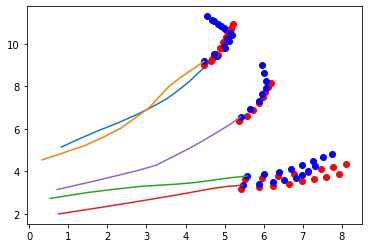

In [321]:
for i in range(90,95):
  plot_prediction(i, scaled = False)

In [316]:
def plot_prediction(test_index = 0, scaled = False):
  m = my_max
  i = inputs_scaled
  o = outputs_scaled
  if scaled == False:
    m = 1
    i = inputs
    o = outputs
  print(m)
  test_ind = test_index
  t = i[test_ind]
  t = t.reshape(1, 12, 2)
  b = model.predict(t)
  b = np.squeeze(b)
  xx = b[:,0] * m
  yy = b[:,1] * m
  check_tar = o[test_ind] * m
  check_input = i[test_ind] * m
  plt.plot(xx, yy, 'ro')
  plt.plot(check_tar[:,0], check_tar[:,1], 'bo')
  plt.plot(check_input[:,0], check_input[:,1])